## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        lines = iofile.readlines()

File ‘sonnets.txt’ already there; not retrieving.



In [3]:
TEXT_START = 45
TEXT_END = -368
lines = lines[TEXT_START : TEXT_END]
assert len(lines) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

lines = [line.lower() for line in lines]
text = ''.join(lines)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
PADDING = '\a'
tokens = sorted(set(text) | {PADDING})

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {token_to_idx[char]: char for char in token_to_idx}

In [7]:
num_tokens = len(token_to_idx)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Converting lines to tokens

Text(0.5, 1.0, 'Lines length distribution')

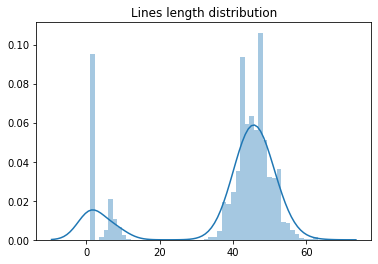

In [8]:
sns.distplot(list(map(len, lines))).set_title('Lines length distribution')

In [9]:
lines = list(filter(lambda line: len(line) > 30, lines))

In [10]:
lines[:5]

['  from fairest creatures we desire increase,\n',
 "  that thereby beauty's rose might never die,\n",
 '  but as the riper should by time decease,\n',
 '  his tender heir might bear his memory:\n',
 '  but thou, contracted to thine own bright eyes,\n']

In [11]:
MAX_LENGTH = max(map(len, lines))
MAX_LENGTH

63

In [12]:
def add_padding(line):
    return line + PADDING * (MAX_LENGTH - len(line))

lines = list(map(add_padding, lines))

In [13]:
def to_index(line):
    return [token_to_idx[char] for char in line]

idx_lines = np.array(list(map(to_index, lines)))

In [14]:
idx_lines

array([[ 2,  2, 18, ...,  0,  0,  0],
       [ 2,  2, 32, ...,  0,  0,  0],
       [ 2,  2, 14, ...,  0,  0,  0],
       ...,
       [ 2,  2, 18, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0]])

In [15]:
def get_batch(size):
    random_idx = np.random.choice(np.arange(0, idx_lines.shape[0]), size=size)
    return torch.tensor(idx_lines[random_idx, :], dtype=int)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [16]:
class VanillaRNN(nn.Module):
    def __init__(self, num_embeddings=num_tokens, embedding_dim=16, hidden_state_dim=256):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.recurrent_dense = nn.Linear(hidden_state_dim + embedding_dim, hidden_state_dim)
        self.hidden_to_logits = nn.Linear(hidden_state_dim, num_embeddings)
    
    def forward(self, x, hidden_state):
        x = self.emb(x)
        next_hidden = torch.tanh(self.recurrent_dense(torch.cat((hidden_state, x), dim=1)))
        logits = self.hidden_to_logits(next_hidden)
        return next_hidden, logits
    
    def initial_state(self, batch_size):
        return torch.zeros((batch_size, self.hidden_state_dim), 
                           dtype=torch.float32, requires_grad=True)

In [17]:
def RNNLoop(rnn, batch, num_tokens=num_tokens):
    batch_size = batch.size(0)
    timesteps = batch.size(1) - 1
    hidden_state = rnn.initial_state(batch_size)
    full_logits = torch.zeros((batch_size, timesteps, num_tokens), dtype=torch.float32)
    for i in range(timesteps):
        hidden_state, logits = rnn(batch.transpose(1, 0)[i], hidden_state)
        full_logits[:, i, :] = logits
    return full_logits

In [18]:
BATCH_SIZE = 256
LR = 0.001
model = VanillaRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

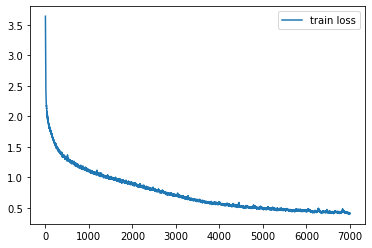

Train loss: 0.41027519255876543


In [19]:
NUM_STEPS = 7000

loss_history = np.zeros(NUM_STEPS, dtype=float)

for i in range(NUM_STEPS):
    batch = get_batch(BATCH_SIZE)
    model_logits = RNNLoop(model, batch).reshape((-1, 39))
    true_classes = batch[:, 1:].reshape(-1)
    loss = criterion(model_logits, true_classes)
    loss_history[i] = loss.item()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
    optimizer.step()
    optimizer.zero_grad()
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(loss_history[:i+1], label='train loss')
        plt.legend()
        plt.show()
    
print(f'Train loss: {loss_history[-20:].mean()}')

In [20]:
def generate_sample(char_rnn, max_length=MAX_LENGTH, seed_phrase=' ', temperature=1):
    char_rnn.eval()
    phrase = seed_phrase
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).transpose(1, 0)
    hidden_state = char_rnn.initial_state(1)
    
    with torch.no_grad():
        for char in x_sequence:
            hidden_state, logits = char_rnn(char, hidden_state)
        
        for _ in range(max_length - len(seed_phrase)):
            probs = nn.Softmax(dim=1)(logits / temperature).numpy().flatten()
            next_token_idx = np.random.choice(np.arange(num_tokens), p=probs)
            phrase += idx_to_token[next_token_idx]
            token_tensor = torch.tensor([next_token_idx], dtype=torch.int64)
            hidden_state, logits = char_rnn(token_tensor, hidden_state)
    
    return phrase

In [21]:
for i in range(4):
    print(generate_sample(model, temperature=0.5, seed_phrase=' ').strip('\a\n '))

which have belime the treass be glowy,
the terms thy self at me:
the base to guments that can say acqueittence stratgly merver
and humble say de exchopit, but it fell abousth's intands me.


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [22]:
class LSTM(nn.Module):
    def __init__(self, num_embeddings=num_tokens, embedding_dim=16, hidden_state_dim=128):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.recurrent = nn.LSTM(embedding_dim, hidden_state_dim, batch_first=True)
        self.hidden_to_logits = nn.Linear(hidden_state_dim, num_embeddings)
        
    def forward(self, x, hidden_state=None):
        out_hidden, state = self.recurrent(self.emb(x), hidden_state)
        logits = self.hidden_to_logits(out_hidden)
        return state, logits

In [23]:
BATCH_SIZE = 256
LR = 0.001
model = LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

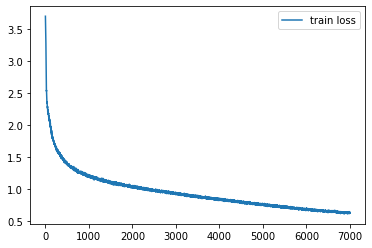

Train loss: 0.6390392363071442


In [25]:
NUM_STEPS = 7000

loss_history = np.zeros(NUM_STEPS, dtype=float)

for i in range(NUM_STEPS):
    batch = get_batch(BATCH_SIZE)
    model_logits = model(batch)[1][:, :-1].reshape((-1, 39))
    true_classes = batch[:, 1:].reshape(-1)
    loss = criterion(model_logits, true_classes)
    loss_history[i] = loss.item()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
    optimizer.step()
    optimizer.zero_grad()
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(loss_history[:i+1], label='train loss')
        plt.legend()
        plt.show()
    
print(f'Train loss: {loss_history[-20:].mean()}')

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [26]:
def generate_sample(rnn_model, max_length=MAX_LENGTH, seed_phrase=' ', temperature=1):
    rnn_model.eval()
    phrase = seed_phrase
    x_sequence = [[token_to_idx[token]] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).transpose(1, 0)
    hidden_state = None
    
    with torch.no_grad():
        for char in x_sequence:
            hidden_state, logits = rnn_model(char, hidden_state)
            
        for _ in range(max_length - len(seed_phrase)):
            probs = nn.Softmax(dim=-1)(logits / temperature).numpy().flatten()
            next_token_idx = np.random.choice(np.arange(num_tokens), p=probs)
            phrase += idx_to_token[next_token_idx]
            token_tensor = torch.tensor([[next_token_idx]], dtype=torch.int64)
            hidden_state, logits = rnn_model(token_tensor, hidden_state)
    
    return phrase

In [27]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1, 2]

for temp in temperatures:
    print(f'Temperature: {temp}')
    for i in range(4):
        print(generate_sample(model, temperature=temp, seed_phrase=' ').strip('\a\n '))
    print()

Temperature: 0.1
the say the eyes to my see thee i seen,
and therefore doth hadn thy self the worst be;
the beauty of thy self are despise,
and therefore doth hadn thy self the worst be;

Temperature: 0.2
then shall to my strongly thousblt me not state,
and in the bett in my self alone,
the world constancy of thy beauty's love,
and so the truth of former doth give;

Temperature: 0.5
the rued of mother's proviened meads.
for whose streasures of their days so deceivest
that in the bloody with thy poor self,
and to the strength on thee, and they growing all.

Temperature: 1
i much cleshs are to time of mine eyes.
will is forting hadver no longer muge;
by are i altworn shope, that thy love should hadvy?
and in by his control; to hearts,

Temperature: 2
that shall in briev, adly wrillst us'sterit,
o! chunlify im thee, and,el ic my kins own smoul,
remed,erfse'ed--gajt
m
'y gilds! that scepppyater imellovidif,



Lower temperatures give lines more similar to each other. However, higher temperatures make text too random. 
I also tried to increase the hidden state dimensionality for LSTM model. At first glance, more complicated model works better, but actually it just copies lines from the train set instead of generating its own text.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [28]:
PATH = 'lstm.pth'

In [29]:
# Saving and loading code here
torch.save(model, PATH)

/home/uladzislaw/anaconda3/envs/dl_py38/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [30]:
model = torch.load(PATH)

In [31]:
for i in range(4):
    print(generate_sample(model, temperature=0.5, seed_phrase=' ').strip('\a\n '))

which my death, the could worst to thy heart.
when i what you as the world is despian;
and there rebloy shall though to me remow'd;
to fair yout thee i cruse of such a dead;


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)